# Simon & Schuster Data Challenge

---

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import fbprophet

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, LabelBinarizer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso

Importing plotly failed. Interactive plots will not work.


First, load the data set by `pandas`.

In [2]:
data = pd.read_csv('sample_data.csv')
print(data.shape)
data.head()

(6539, 106)


,entity,formattype,fromdate,titlecount,titles,todate,author,amazontotalreviews,minappleprice,amazontotalrevenue,...,lumpedpreorderrevenue,amazonsoldunits,amazonpreordersubscriptionrevenue,preordersubscriptionunits,amazonpreordersalesrevenue,maxappleprice,pagelength,pricewassetbypublisher,barnesandnobledistributor,appledistributor
0,Alone in the dark,print,20170418,1,"{'amazontotalreviews': 306, 'minappleprice': 0...",20170419,Frith Banbury,306.0,0,0,...,0,6,0,0,0,0,NaN,NaN,NaN,NaN
1,Alone in the dark,print,20170419,1,"{'amazontotalreviews': 306, 'minappleprice': 0...",20170420,Frith Banbury,306.0,0,702,...,0,7,0,0,0,0,NaN,NaN,NaN,NaN
2,Alone in the dark,print,20170420,1,"{'amazontotalreviews': 306, 'minappleprice': 0...",20170421,Frith Banbury,306.0,0,4914,...,0,7,0,0,0,0,NaN,NaN,NaN,NaN
3,Alone in the dark,print,20170421,1,"{'amazontotalreviews': 306, 'minappleprice': 0...",20170422,Frith Banbury,306.0,0,4212,...,0,6,0,0,0,0,NaN,NaN,NaN,NaN
4,Alone in the dark,print,20170422,1,"{'amazontotalreviews': 306, 'minappleprice': 0...",20170423,Frith Banbury,306.0,0,702,...,0,1,0,0,0,0,NaN,NaN,NaN,NaN


We can see that there are two different entities, **Alone in the Dark** and **The Walking Dead**, for the entire data set. And each of them has three format types: **print**, **ebook**, and **audio**.

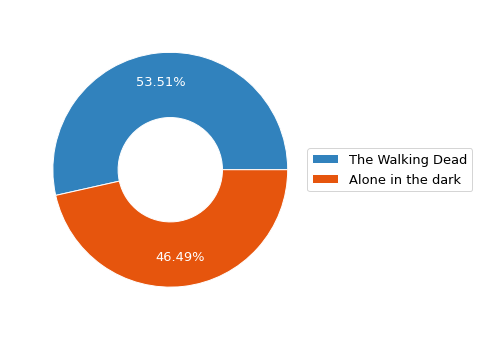

In [3]:
fig = plt.figure(figsize=(6, 6))
vals = np.array(data.entity.value_counts())

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(3)*4)
wedges, a, a = plt.pie(vals, radius=0.9, autopct="%.2f%%", colors=outer_colors, pctdistance=0.75, 
       wedgeprops=dict(width=0.5, edgecolor='w'), textprops={'fontsize': 13, 'color': 'w'})
plt.legend(wedges, data.entity.value_counts().index, fontsize=13, loc="center left", bbox_to_anchor=(0.9, 0, 0, 1))

plt.show()

In [4]:
AITD = data[data['entity'] == 'Alone in the dark']
AITD.shape

(3040, 106)

In [5]:
TWD = data[data['entity'] == 'The Walking Dead']
TWD.shape

(3499, 106)

Here is a pie chart that shows the proportion for all the format types of **Alone in the Dark**, we can see that we have more data for `print` and not so much data for the other two formats. This may lead us to better performance for `print` in our model later.

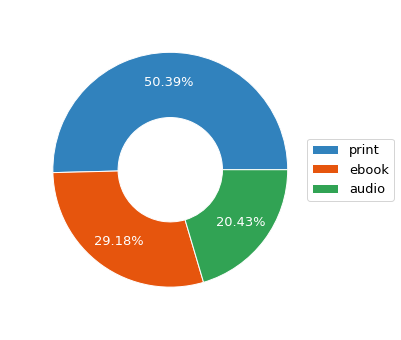

In [6]:
fig = plt.figure(figsize=(6, 6))
vals = np.array(AITD.formattype.value_counts())

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(3)*4)
wedges, a, a = plt.pie(vals, radius=0.9, autopct="%.2f%%", colors=outer_colors, pctdistance=0.75, 
       wedgeprops=dict(width=0.5, edgecolor='w'), textprops={'fontsize': 13, 'color': 'w'})
plt.legend(wedges, AITD.formattype.value_counts().index, fontsize=13, loc="center left", bbox_to_anchor=(0.9, 0, 0, 1))

plt.show()

Therefore, let's take **Alone in the Dark** as an example, and first visualize how each feature looks like.

---

## Alone in the Dark

### EDA

First, let's visualize some of the features to briefly understand our data set.

Here are the plots for all the revenue columns. The black vertical lines indicate the boundary between each format types, namely, **print**, **ebook**, and **audio**. Here we can check that, total revenue equals sales revenue plus subscription revenue, which should be the case.

This could be a target variable that we want to predict later, and we will also need to accumulate the revenue for different items in a single day and see the trend through time.

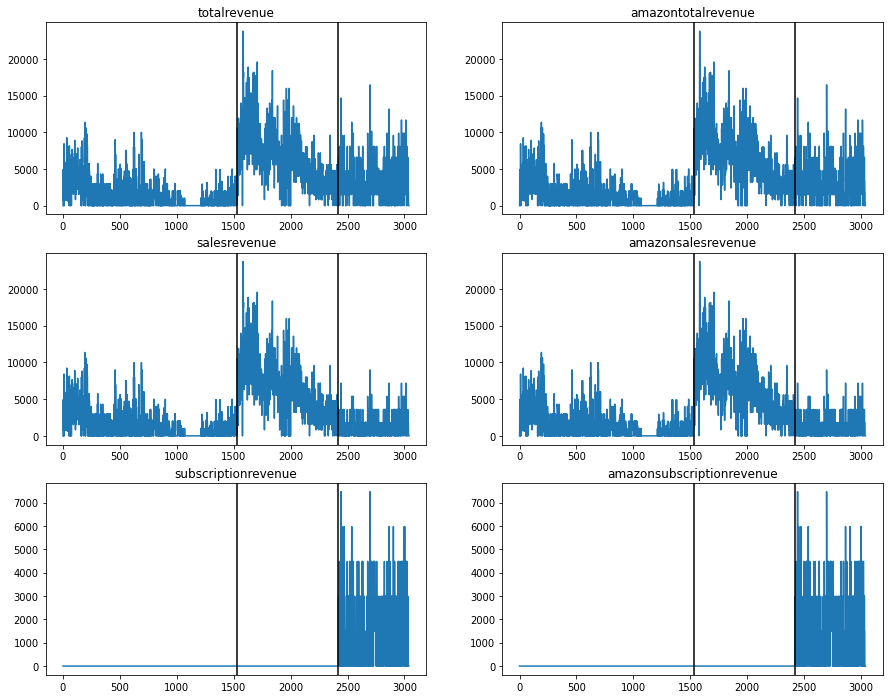

In [7]:
fig, ax = plt.subplots(3, 2, figsize=(15, 12))
features = ['totalrevenue', 'amazontotalrevenue',
            'salesrevenue', 'amazonsalesrevenue',
            'subscriptionrevenue', 'amazonsubscriptionrevenue']
for i in range(6):
    row = i // 2
    col = i % 2
    ax[row, col].plot(getattr(AITD, features[i]))
    ax[row, col].set_title(features[i])
    ax[row, col].axvline(1532, c='black')
    ax[row, col].axvline(2419, c='black')
plt.show()

In [8]:
(AITD.totalrevenue == AITD.salesrevenue + AITD.subscriptionrevenue).unique()

array([ True])

Here I also visualize the **prices** as well as the **units**.

We can see that the units have the same tendency as the revenue, and we can expect that they will have a high correlation with the revenue. I have also verified that total units equal sold units plus subscription units.

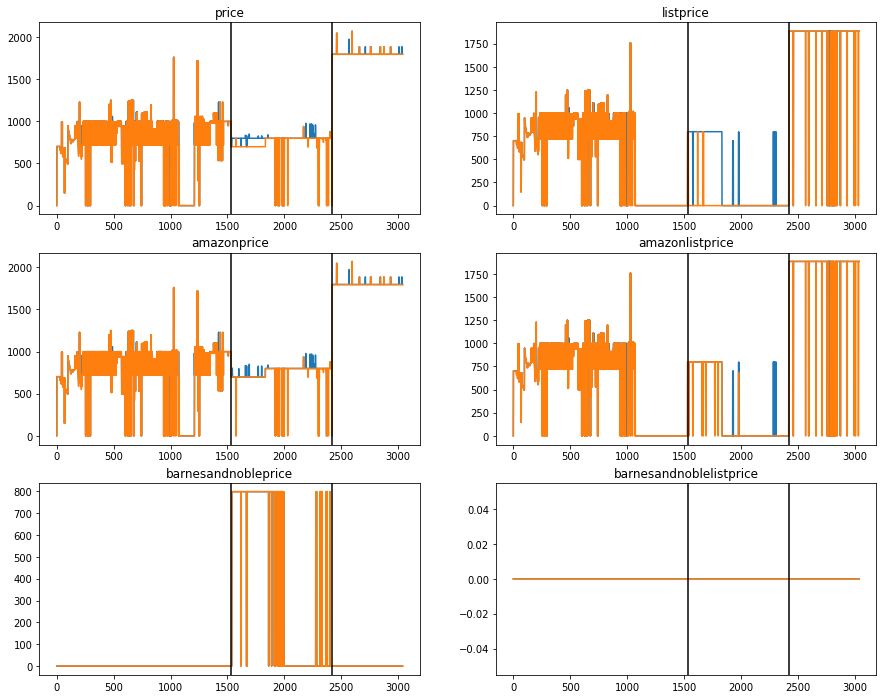

In [9]:
fig, ax = plt.subplots(3, 2, figsize=(15, 12))
features = ['price', 'listprice',
            'amazonprice', 'amazonlistprice',
            'barnesandnobleprice', 'barnesandnoblelistprice']
for i in range(6):
    row = i // 2
    col = i % 2
    ax[row, col].plot(getattr(AITD, 'max'+features[i]))
    ax[row, col].plot(getattr(AITD, 'min'+features[i]))
    ax[row, col].set_title(features[i])
    ax[row, col].axvline(1532, c='black')
    ax[row, col].axvline(2419, c='black')
plt.show()

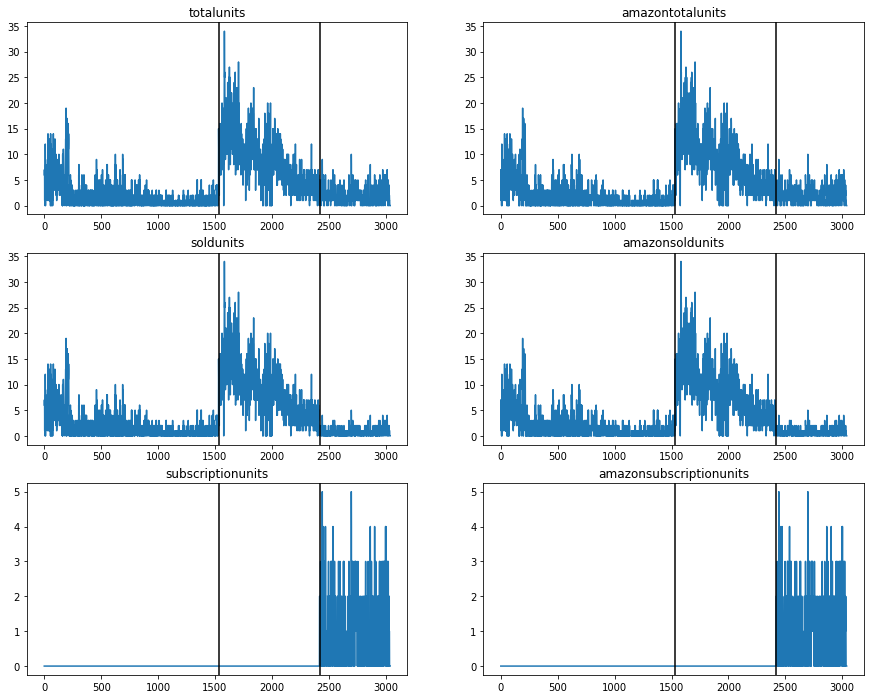

In [10]:
fig, ax = plt.subplots(3, 2, figsize=(15, 12))
features = ['totalunits', 'amazontotalunits',
            'soldunits', 'amazonsoldunits',
            'subscriptionunits', 'amazonsubscriptionunits']
for i in range(6):
    row = i // 2
    col = i % 2
    ax[row, col].plot(getattr(AITD, features[i]))
    ax[row, col].set_title(features[i])
    ax[row, col].axvline(1532, c='black')
    ax[row, col].axvline(2419, c='black')
plt.show()

In [11]:
(AITD.totalunits == AITD.soldunits + AITD.subscriptionunits).unique()

array([ True])

Here since we have multiple data instances for a single day, in order to accumulate data and visualize them, we need to convert the `fromdate` and `todate` features from `int` to `Timestamp`. And the following are visualizations on `totalrevenue` and `maxprice`. We can see that there is a period of time that `totalrevenue` is zero. I think that this is because our data just zeros out all the negative values and so this is only the positive part. This may affect our prediction if we want to use time series models to predict the trend.

It is hard to get a clear correlation between `maxprice` and `totalrevenue`.

In [12]:
AITD_time = [datetime.datetime.strptime(str(i), '%Y%m%d') for i in AITD[AITD.formattype == 'print'].fromdate.unique()]

AITD['fromdate'] = [datetime.datetime.strptime(str(i), '%Y%m%d') for i in AITD.fromdate]
AITD['todate'] = [datetime.datetime.strptime(str(i), '%Y%m%d') for i in AITD.todate]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


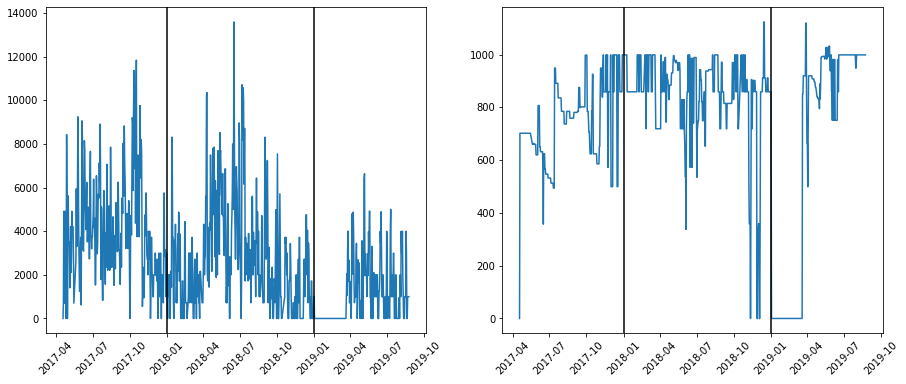

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].plot(AITD[AITD['formattype']=='print'].groupby('fromdate').sum().totalrevenue)
ax[0].axvline(datetime.datetime.strptime('20180101', '%Y%m%d'), color='black')
ax[0].axvline(datetime.datetime.strptime('20190101', '%Y%m%d'), color='black')

ax[1].plot(AITD[AITD['formattype']=='print'].groupby('fromdate').mean().maxprice)
ax[1].axvline(datetime.datetime.strptime('20180101', '%Y%m%d'), color='black')
ax[1].axvline(datetime.datetime.strptime('20190101', '%Y%m%d'), color='black')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)

plt.show()

Here I compute the **correlation matrix** between revenue, units, and prices. Correlation coefficient represents the linear relationship of two variables, range from -1 to 1, represents negative and positive linear relationships. The higher the absolute value, the stronger the relationship. We can see that there is a strong correlation between revenue and units, and between max and min prices, but there is no strong correlation between prices and units. Therefore, I decided to use all the features except those for revenue and units, to make a prediction on the total units.

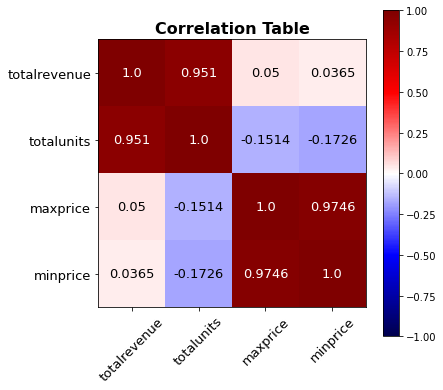

In [14]:
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(111)
features = ['totalrevenue', 'totalunits', 'maxprice', 'minprice']
corr = AITD[features].corr().values
im = plt.imshow(corr, vmax=1, vmin=-1, cmap='seismic')
cbar = ax.figure.colorbar(im, ax=ax)
ax.set_xticks(np.arange(len(features)))
ax.set_yticks(np.arange(len(features)))
plt.yticks(range(len(features)), features, fontsize=13)
plt.xticks(range(len(features)), features, fontsize=13, rotation=45)
for i in range(len(features)):
    for j in range(len(features)):
        text = ax.text(i, j, round(corr[j][i], 4), ha="center", va="center", color="w" if abs(corr[j, i]) > 0.5 else "black", fontsize=13)
ax.set_title('Correlation Table', fontsize=16, fontweight='bold')
plt.show()

### Data Preprocessing

Since we only have two different entities, I decided to run separate models on each of the entity, to make the model learn easier.

In order to fit these features to a model, I also convert the `fromdate` and `todate` features to binary indicators for the year, month, day and weekdays. This is a typical way of using time stamp data. Data also shows that, our data spans from April 2017 to August 2019, therefore later we can try to run a time series model to predict the trend for the future.

In [15]:
AITD['fromyear'] = [i.year for i in AITD.fromdate]
AITD['frommonth'] = [i.month for i in AITD.fromdate]
AITD['fromweek'] = [i.weekday() for i in AITD.fromdate]
AITD['fromday'] = [i.day for i in AITD.fromdate]
AITD['toyear'] = [i.year for i in AITD.todate]
AITD['tomonth'] = [i.month for i in AITD.todate]
AITD['toweek'] = [i.weekday() for i in AITD.todate]
AITD['today'] = [i.day for i in AITD.todate]

AITD.drop('fromdate', axis=1, inplace=True)
AITD.drop('todate', axis=1, inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [16]:
week = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
for i in ['from', 'to']:
    for j in ['year', 'month', 'week', 'day']:
        lb = LabelBinarizer().fit(AITD[i+j])
        AITD_bi = pd.DataFrame(lb.transform(AITD[i+j]), columns=[i+'m'+x if j=='month' else i+week[int(x)] if j=='week' else i+x for x in AITD[i+j].unique().astype('str')])
        AITD = pd.concat([AITD, AITD_bi], axis=1)
        AITD.drop(i+j, axis=1, inplace=True)

Here I print all the categorical features, with the number of categories in it. Since we cannot directly fit models on words easily, we need to turn all categories to binary indicators, that takes value 0 and 1 to indicate whether our instance belongs to this category or not. We can see that most of the categorical features have 1 to 2 categories, and so we can turn them into binary features. The column `titles` has 1035 categories, which contains almost all information about this dataset in a single string, and so we will not take this column as a feature for the model. For features like `amazoncategories` and `formats`, we need to turn each category into binary indicators for the model as well.

In [17]:
print('Number of categories:')
for i in AITD.columns:
    if AITD[i].dtype == 'object':
        AITD[i] = AITD[i].fillna('None')
        cat = AITD[i].unique()
        print(i, ':', len(cat))

Number of categories:
entity : 1
formattype : 3
titles : 1035
author : 1
datepublished : 9
publishertype : 2
amazoncategories : 20
publisherparent : 2
formats : 11
barnesandnobledistributor : 2
appledistributor : 1


In [18]:
for i in AITD.columns:
    if AITD[i].dtype == 'object':
        AITD[i] = AITD[i].fillna('None')
        cat = AITD[i].unique()
        if 1 < len(cat) < 300:
            le = LabelEncoder()
            le.fit(cat)
            AITD['n_'+i] = le.transform(AITD[i])

In [19]:
for i in ['amazoncategories', 'formats']:
    lb = LabelBinarizer().fit(AITD['n_'+i])
    AITD_bi = pd.DataFrame(lb.transform(AITD['n_'+i]), columns=AITD[i].unique())
    AITD = pd.concat([AITD, AITD_bi], axis=1)
    AITD.drop('n_'+i, axis=1, inplace=True)

Now I extract the name of the feature columns that will be used in our model. I also split the data by format types, since different format type tends to have very different behavior, so we can use different models to fit them.

In [20]:
features = []
for i in AITD.columns:
    if AITD[i].dtype != 'object' and i[-7:] != 'revenue' and i[-5:] != 'units':
        features += [i]
        
features_short = [i if len(i) < 50 else i[:13]+'...'+i[-13:] for i in features]

In [21]:
AITD_1 = AITD[AITD.formattype == 'print']
AITD_2 = AITD[AITD.formattype == 'ebook']
AITD_3 = AITD[AITD.formattype == 'audio']

Since here we have more than 100 features, including all the binary indicators that I have added, I want to do a principal component analysis to have a rough estimation about how many features do we need to represents the data set. The principal component analysis method finds the direction in the data space that has the highest variance, and thus has the strongest explainatory power in the dataset. Here I look at the singular values, which indicates how strong each principal direction is. The result shows that there are 7 principal directions that represent most of the information in our data set. This could be a guideline for us to do regularization on features later.

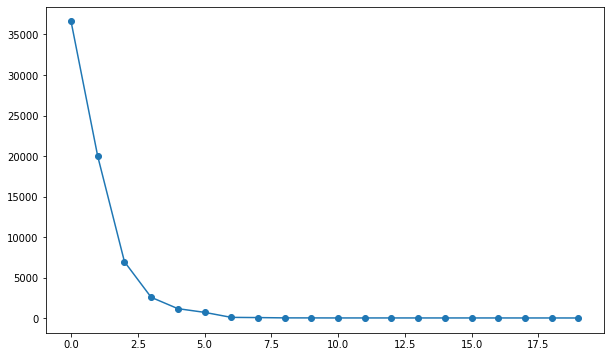

In [22]:
pca = PCA()
pca.fit(AITD_1[features].fillna(0))
plt.figure(figsize=(10, 6))
plt.plot(pca.singular_values_[:20], 'o-')
plt.show()

### Baseline model: Lasso regression

Lasso regression is a linear regression with $L_1$ regularization on the coefficients, and thus will try to use as fewer coefficients as it can to make a prediction. Here I choose Lasso regression to be my baseline, since lasso regression is easy to interpret and has the ability to regularize the coefficient for useless features to zero. We can also see if there are linear relationships between our features and the target variable.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(AITD_1[features].fillna(0), AITD_1['totalunits'])
lr = Lasso(alpha=0.003, max_iter=1e6).fit(X_train, y_train)

print('MSE loss (training): {:.4f}'.format(mean_squared_error(lr.predict(X_train), y_train)))
print('MSE loss (test): {:.4f}'.format(mean_squared_error(lr.predict(X_test), y_test)))

MSE loss (training): 3.2083
MSE loss (test): 4.2351


In [24]:
feature_coef = pd.DataFrame(features_short, columns=['features'])
feature_coef['coef'] = pd.DataFrame(lr.coef_)
feature_coef.sort_values(by='coef', ascending=False, inplace=True)
feature_coef.reset_index(drop=True, inplace=True)
feature_coef = feature_coef[np.abs(feature_coef['coef']) != 0]

Here are the coefficients that Lasso regression gets for each feature. The bar chart shows the magnitude of each coefficient. A bar on the left of the vertical axis indicates that it's negative. Those features with names start by `from` or `to` are binary indicators for `fromdate` and `todate`. We can see that our model heavily relies on those features. The features with `...` in between are abbreviations of features extracted from the amazon categories.

We can see that the Lasso regression still maintains more than 30 features to have significant coefficients.

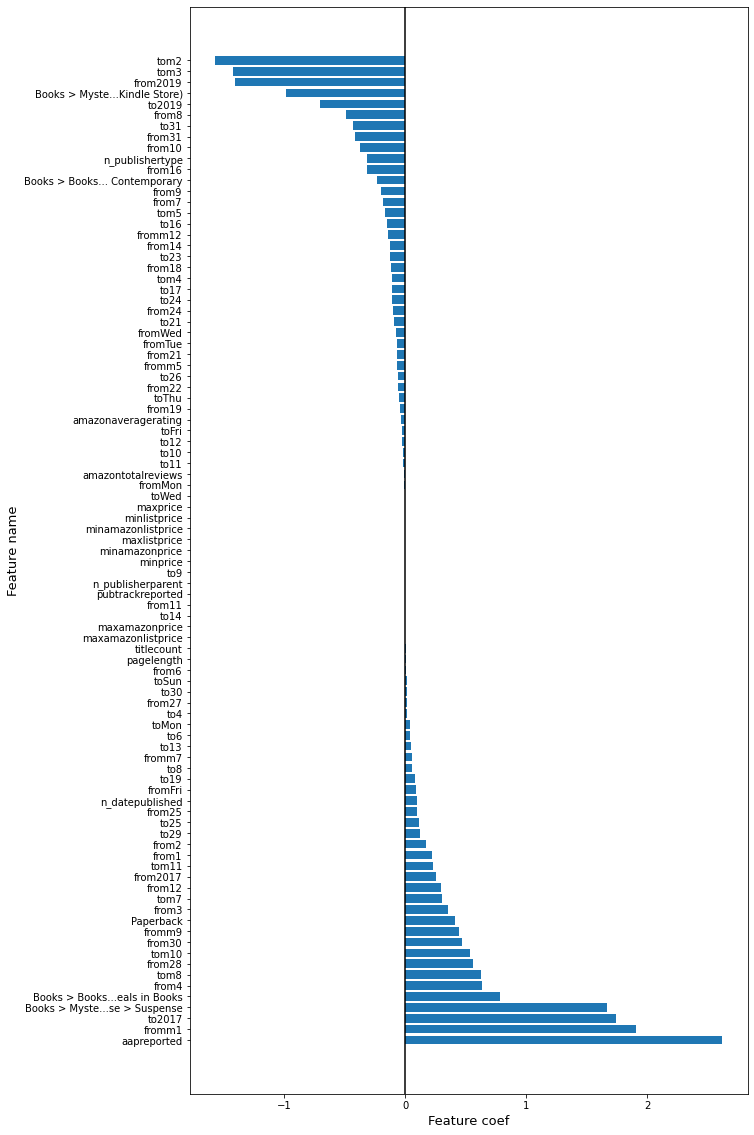

In [25]:
plt.figure(figsize=(10,20))
plt.barh(feature_coef['features'], feature_coef['coef'])
plt.axvline(c='black')
plt.xlabel('Feature coef', fontsize=13)
plt.ylabel('Feature name', fontsize=13)
plt.show()

### Gradient Boosting model

Our next choice would be a gradient boosting model. Since it contains assembles of decision trees, we can also regularize our model easily. The gradient boosting model also tells us the feature importance, which can help us to interpret our model. We can see that our gradient boosting model has a much better MSE loss than the Lasso regression.

I also use a grid search cross-validation to find the best parameters for the gradient boosting model.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(AITD_1[features].fillna(0), AITD_1['totalunits'])
gb = GradientBoostingRegressor(max_depth=4, min_samples_leaf=16, min_samples_split=2).fit(X_train, y_train)

print('MSE loss (training): {:.4f}'.format(mean_squared_error(gb.predict(X_train), y_train)))
print('MSE loss (test): {:.4f}'.format(mean_squared_error(gb.predict(X_test), y_test)))

MSE loss (training): 1.8950
MSE loss (test): 2.7813


In [29]:
grid_values = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],\
               'min_samples_split': [2, 4, 8, 16, 32, 64, 100],\
               'min_samples_leaf': [1, 2, 4, 8, 16, 32, 64, 100]}
grid_gb_mse = GridSearchCV(gb, param_grid = grid_values, scoring = 'neg_mean_squared_error', cv=10)
grid_gb_mse.fit(X_train, y_train)

print('Grid best parameter (min. MSE): ', grid_gb_mse.best_params_)
print('Grid best score (MSE): ', grid_gb_mse.best_score_)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Grid best parameter (min. MSE):  {'max_depth': 4, 'min_samples_leaf': 16, 'min_samples_split': 2}
Grid best score (MSE):  -2.647318530330083


Here is the plot that shows **the top 14 features** that are used by the gradient boosting according to feature importance. We can see that features like `to2017` still provides a lot of information to our data.

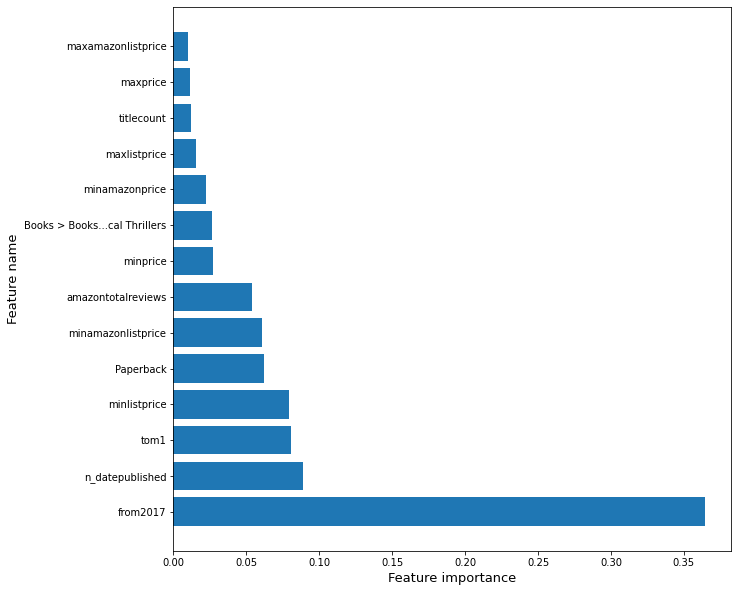

In [27]:
plt.figure(figsize=(10,10))
feature_importance = pd.DataFrame(features_short, columns=['features_short'])
feature_importance['features'] = pd.DataFrame(features)
feature_importance['importance'] = pd.DataFrame(gb.feature_importances_)
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
feature_importance.reset_index(drop=True, inplace=True)
feature_importance = feature_importance[np.abs(feature_importance['importance']) != 0]
plt.barh(feature_importance['features_short'][:14], feature_importance['importance'][:14])
plt.xlabel('Feature importance', fontsize=13)
plt.ylabel('Feature name', fontsize=13)
plt.show()

Here is the plot that shows our prediction as well as the target values. However, it is hard to see how our model performs visualizing this way. Therefore, I decided to plot the true value as the x-axis and the predicted value as the y-axis to form a scatter plot, and so we will expect that a good model will have points clustered along the 45-degree line.

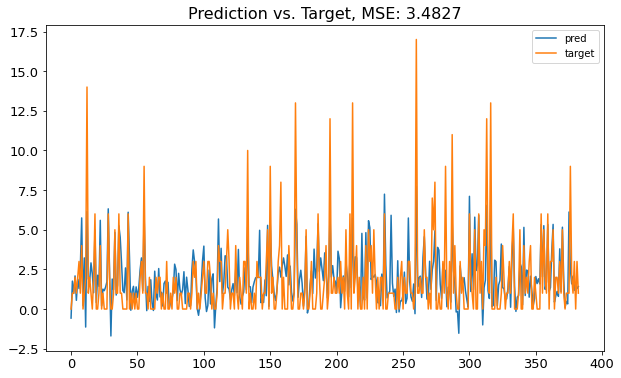

In [28]:
y_pred = lr.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(y_pred, label='pred')
plt.plot(y_test.values, label='target')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Prediction vs. Target, MSE: {:.4f}'.format(mean_squared_error(y_pred, y_test)), fontsize=16)
plt.legend()
plt.show()

Here are the results for Lasso regression and gradient boosting. We can see that Lasso regression obtains a lot of the information and is able to make good predictions. However, the gradient boosting model has a better performance, indicates that there are still non-linear relationships between the features and the target variable.

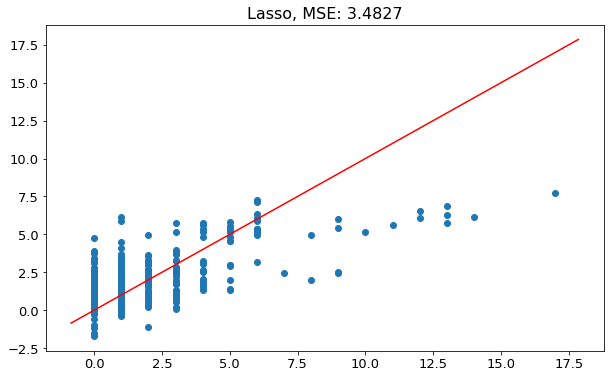

In [29]:
y_pred = lr.predict(X_test)

ax = plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
x = np.linspace(*plt.xlim())
plt.plot(x, x, c='r')
plt.title('Lasso, MSE: {:.4f}'.format(mean_squared_error(y_pred, y_test)), fontsize=16)
plt.show()

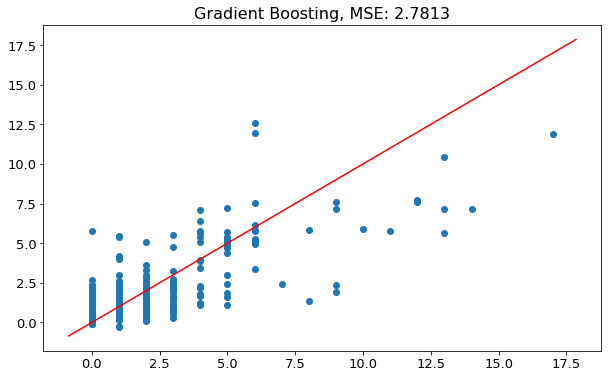

In [30]:
y_pred = gb.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
x = np.linspace(*plt.xlim())
plt.plot(x, x, c='r')
plt.title('Gradient Boosting, MSE: {:.4f}'.format(mean_squared_error(y_pred, y_test)), fontsize=16)
plt.show()

Now I want to have fewer features for our model. I take the **top-12** and **top-7** features from our data, and build a gradient boosting model to make predictions and here is the result. The MSE scores for top-7, top-12 are 2.5894 and 2.4214, respectively, compared with the 2.7813 for the model using all features. We find out that the model that only uses the top-12 and top-7 most important features achieves a score that are higher than the model with all features available.

It is because that the model with only the most important features already gets the main structure of the data, and avoids some small turbulence and noise from other features, thus makes the model easier to learn from it. However it is only just one single try for our models, we need to let the model fit for multiple times like bootstrap, to see whether these results are stable.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(AITD_1[feature_importance['features'][:12].values], AITD_1['totalunits'])
gb = GradientBoostingRegressor(max_depth=4, min_samples_leaf=16, min_samples_split=2).fit(X_train, y_train)

print(feature_importance['features'][:12].values)
print('MSE loss (training): {:.4f}'.format(mean_squared_error(gb.predict(X_train), y_train)))
print('MSE loss (test): {:.4f}'.format(mean_squared_error(gb.predict(X_test), y_test)))

['from2017' 'n_datepublished' 'tom1' 'minlistprice' 'Paperback'
 'minamazonlistprice' 'amazontotalreviews' 'minprice'
 'Books > Books on CD > Mystery & Thrillers ; Books > Books on CD > Authors, A-Z > ( C ) > Clark, Mary Higgins ; Books > Books on CD > Authors, A-Z ; Books > Books on CD > Authors, A-Z > ( C ) ; Books > Books on CD ; Books > Books on CD > Literature & Fiction > General ; Books > Books on CD > Literature & Fiction ; Books > Deals in Books ; Books > Mystery, Thriller & Suspense > Thrillers & Suspense > Psychological Thrillers'
 'minamazonprice' 'maxlistprice' 'titlecount']
MSE loss (training): 2.1990
MSE loss (test): 2.5894


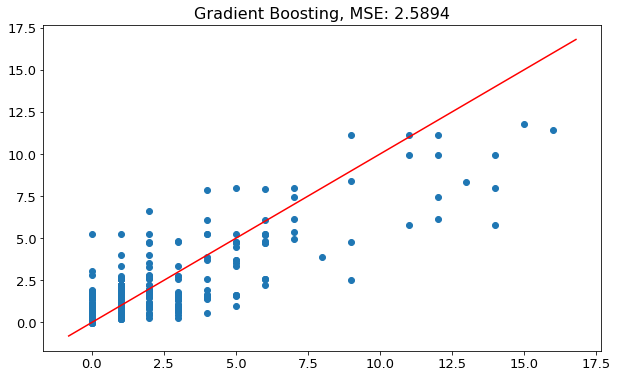

In [32]:
y_pred = gb.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
x = np.linspace(*plt.xlim())
plt.plot(x, x, c='r')
plt.title('Gradient Boosting, MSE: {:.4f}'.format(mean_squared_error(y_pred, y_test)), fontsize=16)
plt.show()

In [33]:
X_train, X_test, y_train, y_test = train_test_split(AITD_1[feature_importance['features'][:7].values], AITD_1['totalunits'])
gb = GradientBoostingRegressor(max_depth=4, min_samples_leaf=16, min_samples_split=2).fit(X_train, y_train)

print('MSE loss (training): {:.4f}'.format(mean_squared_error(gb.predict(X_train), y_train)))
print('MSE loss (test): {:.4f}'.format(mean_squared_error(gb.predict(X_test), y_test)))

MSE loss (training): 2.3802
MSE loss (test): 2.4214


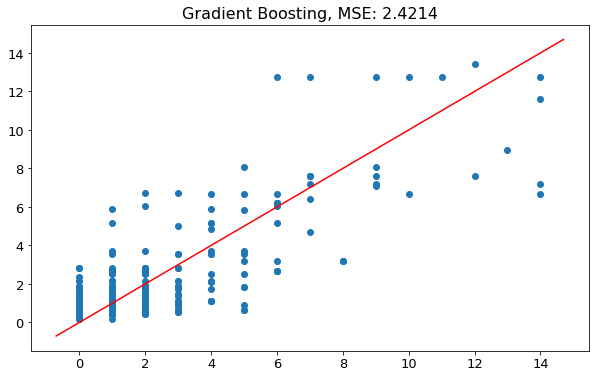

In [34]:
y_pred = gb.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
x = np.linspace(*plt.xlim())
plt.plot(x, x, c='r')
plt.title('Gradient Boosting, MSE: {:.4f}'.format(mean_squared_error(y_pred, y_test)), fontsize=16)
plt.show()

The following are gradient boosting models for the **ebooks** and **audios** of Alone in the Dark. For the model on ebooks, the performance seems to be better, and the most important features that are related is the amazon total reviews, which make sense in our case. For the model on audios, however, our model does not predict very well, it tends to predict everything around the average values only. It may be becausewe have less data for audiobooks, and most of the features are completely silent for audiobooks as well.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(AITD_2[features].fillna(0), AITD_2['totalunits'], random_state = 0)
gb = GradientBoostingRegressor(max_depth=4, min_samples_leaf=16, min_samples_split=2).fit(X_train, y_train)

print('MSE loss (training): {:.4f}'.format(mean_squared_error(gb.predict(X_train), y_train)))
print('MSE loss (test): {:.4f}'.format(mean_squared_error(gb.predict(X_test), y_test)))

MSE loss (training): 8.8371
MSE loss (test): 14.2325


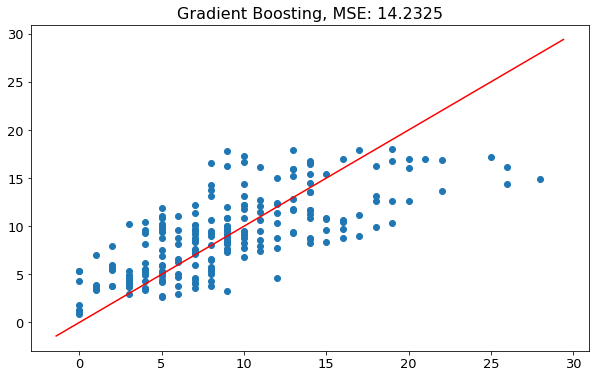

In [36]:
y_pred = gb.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
x = np.linspace(*plt.xlim())
plt.plot(x, x, c='r')
plt.title('Gradient Boosting, MSE: {:.4f}'.format(mean_squared_error(y_pred, y_test)), fontsize=16)
plt.show()

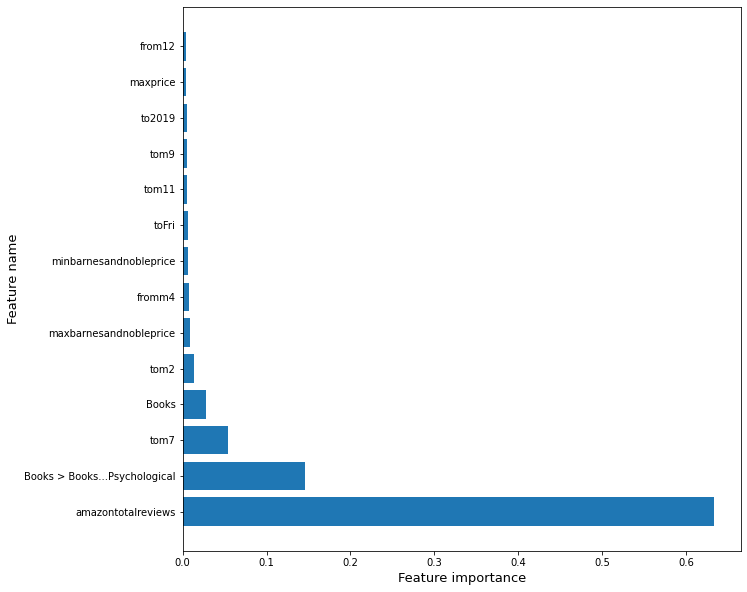

In [37]:
plt.figure(figsize=(10,10))
feature_importance = pd.DataFrame(features_short, columns=['features_short'])
feature_importance['features'] = pd.DataFrame(features)
feature_importance['importance'] = pd.DataFrame(gb.feature_importances_)
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
feature_importance.reset_index(drop=True, inplace=True)
feature_importance = feature_importance[np.abs(feature_importance['importance']) != 0]
plt.barh(feature_importance['features_short'][:14], feature_importance['importance'][:14])
plt.xlabel('Feature importance', fontsize=13)
plt.ylabel('Feature name', fontsize=13)
plt.show()

In [38]:
X_train, X_test, y_train, y_test = train_test_split(AITD_3[features].fillna(0), AITD_3['totalunits'], random_state = 0)
gb = GradientBoostingRegressor(max_depth=4, min_samples_leaf=16, min_samples_split=2).fit(X_train, y_train)

print('MSE loss (training): {:.4f}'.format(mean_squared_error(gb.predict(X_train), y_train)))
print('MSE loss (test): {:.4f}'.format(mean_squared_error(gb.predict(X_test), y_test)))

MSE loss (training): 1.9597
MSE loss (test): 2.7123


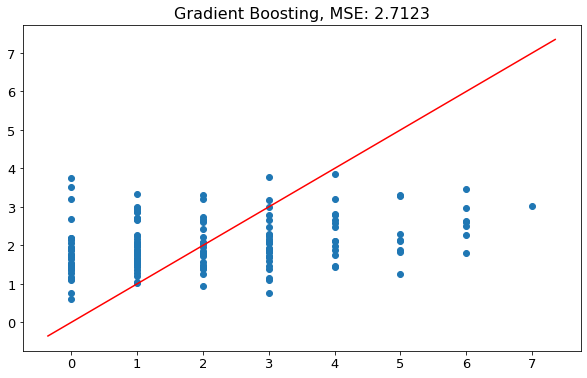

In [39]:
y_pred = gb.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
x = np.linspace(*plt.xlim())
plt.plot(x, x, c='r')
plt.title('Gradient Boosting, MSE: {:.4f}'.format(mean_squared_error(y_pred, y_test)), fontsize=16)
plt.show()

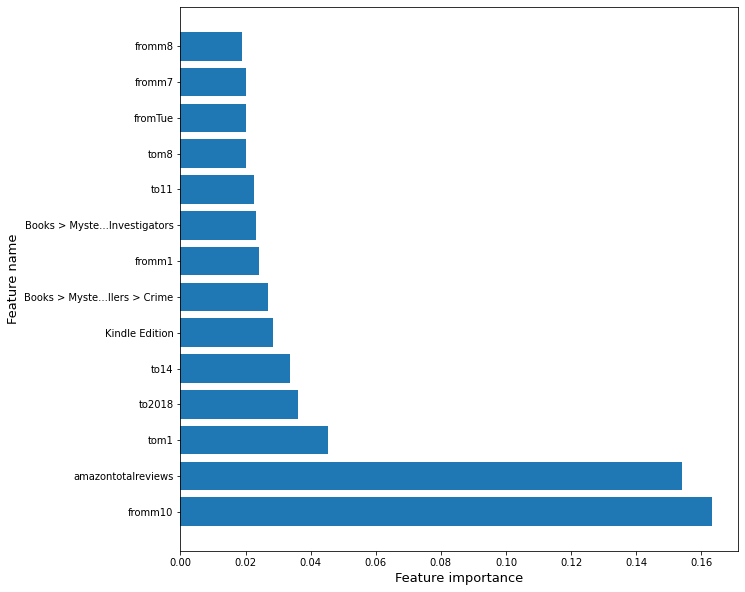

In [40]:
plt.figure(figsize=(10,10))
feature_importance = pd.DataFrame(features_short, columns=['features_short'])
feature_importance['features'] = pd.DataFrame(features)
feature_importance['importance'] = pd.DataFrame(gb.feature_importances_)
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
feature_importance.reset_index(drop=True, inplace=True)
feature_importance = feature_importance[np.abs(feature_importance['importance']) != 0]
plt.barh(feature_importance['features_short'][:14], feature_importance['importance'][:14])
plt.xlabel('Feature importance', fontsize=13)
plt.ylabel('Feature name', fontsize=13)
plt.show()

# The Walking Dead

In [41]:
TWD = data[data['entity'] == 'The Walking Dead'].reset_index(drop=True)
TWD.shape

(3499, 106)

Here I also visualize the proportion of each format type, as well as some important features. We can see that there are outliers in the revenue and units data, that may need to be taken care of later.

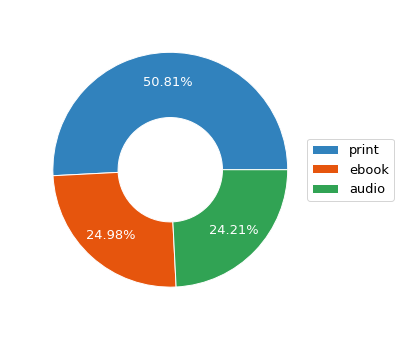

In [42]:
fig = plt.figure(figsize=(6, 6))
vals = np.array(TWD.formattype.value_counts())

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(3)*4)
wedges, a, a = plt.pie(vals, radius=0.9, autopct="%.2f%%", colors=outer_colors, pctdistance=0.75, 
       wedgeprops=dict(width=0.5, edgecolor='w'), textprops={'fontsize': 13, 'color': 'w'})
plt.legend(wedges, TWD.formattype.value_counts().index, fontsize=13, loc="center left", bbox_to_anchor=(0.9, 0, 0, 1))

plt.show()

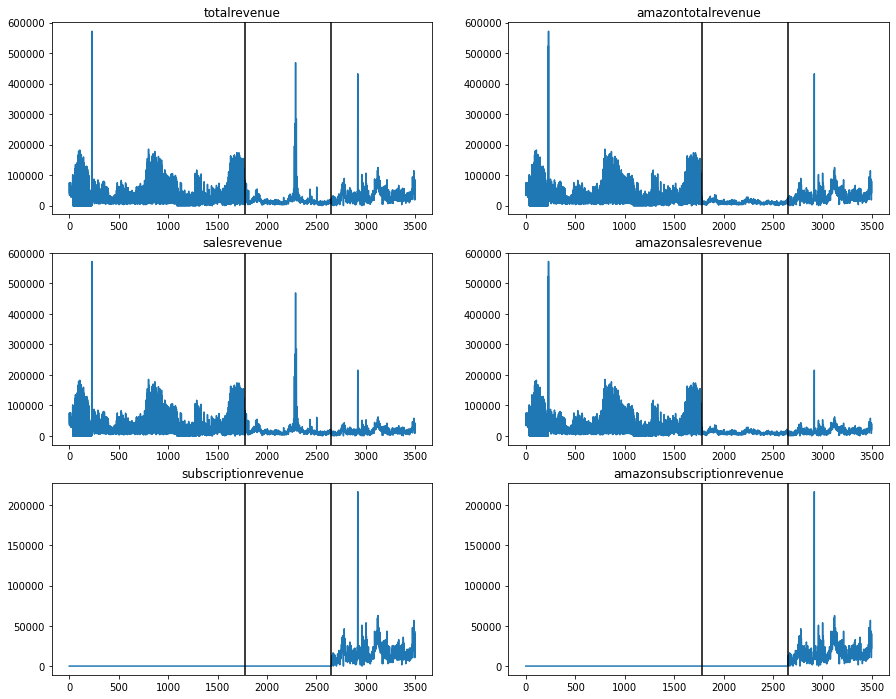

In [43]:
fig, ax = plt.subplots(3, 2, figsize=(15, 12))
features = ['totalrevenue', 'amazontotalrevenue',
            'salesrevenue', 'amazonsalesrevenue',
            'subscriptionrevenue', 'amazonsubscriptionrevenue']
for i in range(6):
    row = i // 2
    col = i % 2
    ax[row, col].plot(getattr(TWD, features[i]))
    ax[row, col].set_title(features[i])
    ax[row, col].axvline(1778, c='black')
    ax[row, col].axvline(2652, c='black')
plt.show()

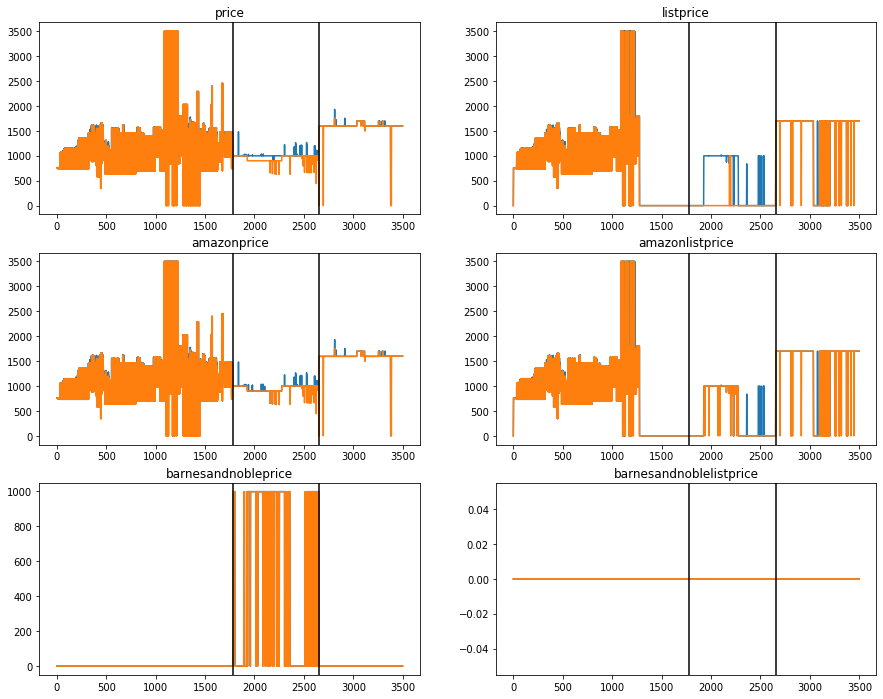

In [44]:
fig, ax = plt.subplots(3, 2, figsize=(15, 12))
features = ['price', 'listprice',
            'amazonprice', 'amazonlistprice',
            'barnesandnobleprice', 'barnesandnoblelistprice']
for i in range(6):
    row = i // 2
    col = i % 2
    ax[row, col].plot(getattr(TWD, 'max'+features[i]))
    ax[row, col].plot(getattr(TWD, 'min'+features[i]))
    ax[row, col].set_title(features[i])
    ax[row, col].axvline(1778, c='black')
    ax[row, col].axvline(2652, c='black')
plt.show()

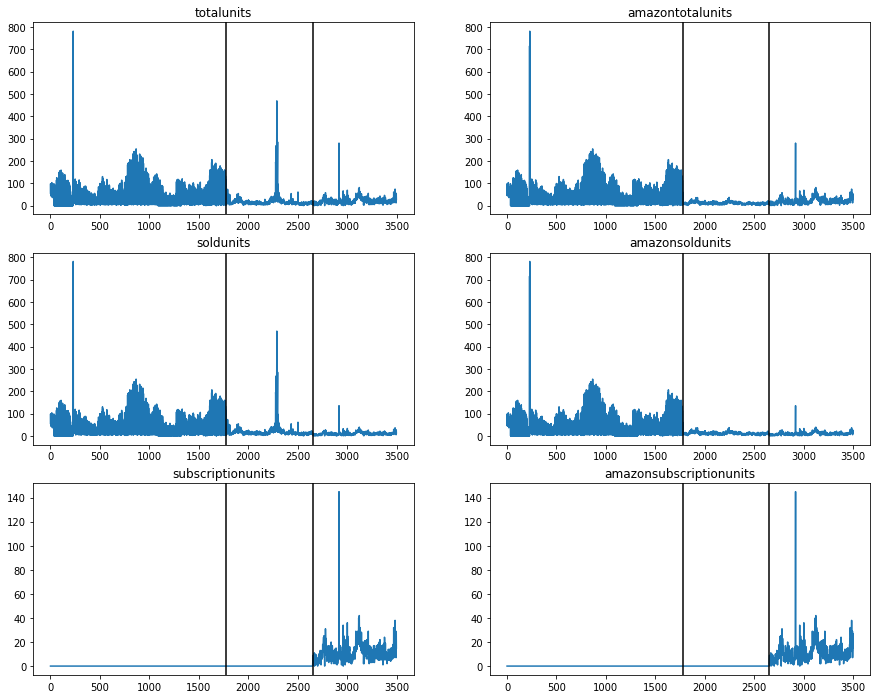

In [45]:
fig, ax = plt.subplots(3, 2, figsize=(15, 12))
features = ['totalunits', 'amazontotalunits',
            'soldunits', 'amazonsoldunits',
            'subscriptionunits', 'amazonsubscriptionunits']
for i in range(6):
    row = i // 2
    col = i % 2
    ax[row, col].plot(getattr(TWD, features[i]))
    ax[row, col].set_title(features[i])
    ax[row, col].axvline(1778, c='black')
    ax[row, col].axvline(2652, c='black')
plt.show()

Here are the visualizations for the revenue and prices through time for **The Walking Dead**, and we can see a clear stationary pattern for each year in the revenue data. For the outliers that appear in our data, I suspect that there might be special events about **The Walking Dead** during those days, and thus heavily affects the revenue. However, we do not have features that capture those kinds of information.

In [46]:
TWD_time = [datetime.datetime.strptime(str(i), '%Y%m%d') for i in TWD[TWD.formattype == 'print'].fromdate.unique()]

TWD['fromdate'] = [datetime.datetime.strptime(str(i), '%Y%m%d') for i in TWD.fromdate]
TWD['todate'] = [datetime.datetime.strptime(str(i), '%Y%m%d') for i in TWD.todate]

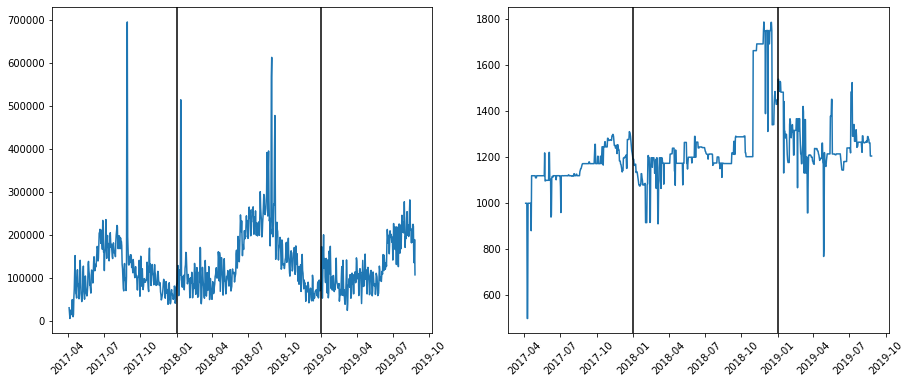

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].plot(TWD[TWD['formattype']=='print'].groupby('fromdate').sum().totalrevenue)
ax[0].axvline(datetime.datetime.strptime('20180101', '%Y%m%d'), color='black')
ax[0].axvline(datetime.datetime.strptime('20190101', '%Y%m%d'), color='black')

ax[1].plot(TWD[TWD['formattype']=='print'].groupby('fromdate').mean().maxprice)
ax[1].axvline(datetime.datetime.strptime('20180101', '%Y%m%d'), color='black')
ax[1].axvline(datetime.datetime.strptime('20190101', '%Y%m%d'), color='black')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)

plt.show()

Here is the correlation matrix about the revenue, units, and price as well. However, this time we see a stronger correlation between prices and revenue, and we can expect that prices will be important features later in our model.

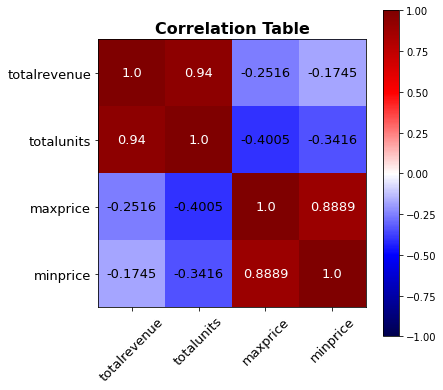

In [48]:
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(111)
features = features = ['totalrevenue', 'totalunits', 'maxprice', 'minprice']
corr = TWD[features].corr().values
im = plt.imshow(corr, vmax=1, vmin=-1, cmap='seismic')
cbar = ax.figure.colorbar(im, ax=ax)
ax.set_xticks(np.arange(len(features)))
ax.set_yticks(np.arange(len(features)))
plt.yticks(range(len(features)), features, fontsize=13)
plt.xticks(range(len(features)), features, fontsize=13, rotation=45)
for i in range(len(features)):
    for j in range(len(features)):
        text = ax.text(i, j, round(corr[j][i], 4), ha="center", va="center", color="w" if abs(corr[j, i]) > 0.5 else "black", fontsize=13)
ax.set_title('Correlation Table', fontsize=16, fontweight='bold')
plt.show()

We do the similar preprocessing steps as what we previously have, and split the data by the format types as well.

In [49]:
TWD['fromyear'] = [i.year for i in TWD.fromdate]
TWD['frommonth'] = [i.month for i in TWD.fromdate]
TWD['fromweek'] = [i.weekday() for i in TWD.fromdate]
TWD['fromday'] = [i.day for i in TWD.fromdate]
TWD['toyear'] = [i.year for i in TWD.todate]
TWD['tomonth'] = [i.month for i in TWD.todate]
TWD['toweek'] = [i.weekday() for i in TWD.todate]
TWD['today'] = [i.day for i in TWD.todate]

TWD.drop('fromdate', axis=1, inplace=True)
TWD.drop('todate', axis=1, inplace=True)

In [50]:
week = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
for i in ['from', 'to']:
    for j in ['year', 'month', 'week', 'day']:
        lb = LabelBinarizer().fit(TWD[i+j])
        TWD_bi = pd.DataFrame(lb.transform(TWD[i+j]),\
            columns=[i+'m'+x if j=='month' else i+week[int(x)] if j=='week' else i+x for x in TWD[i+j].unique().astype('str')])
        TWD = pd.concat([TWD, TWD_bi], axis=1)
        TWD.drop(i+j, axis=1, inplace=True)

In [51]:
for i in TWD.columns:
    if TWD[i].dtype == 'object':
        TWD[i] = TWD[i].fillna('None')
        cat = TWD[i].unique()
        if 1 < len(cat) < 300:
            le = LabelEncoder()
            le.fit(cat)
            TWD['n_'+i] = le.transform(TWD[i])

In [52]:
for i in ['amazoncategories', 'formats']:
    lb = LabelBinarizer().fit(TWD['n_'+i])
    TWD_bi = pd.DataFrame(lb.transform(TWD['n_'+i]), columns=TWD[i].unique())
    TWD = pd.concat([TWD, TWD_bi], axis=1)
    TWD.drop('n_'+i, axis=1, inplace=True)

In [53]:
features = []
for i in TWD.columns:
    if TWD[i].dtype != 'object' and i[-7:] != 'revenue' and i[-5:] != 'units':
        features += [i]

features_short = [i if len(i) < 50 else i[:13]+'...'+i[-13:] for i in features]

In [54]:
TWD_1 = TWD[TWD.formattype == 'print']
TWD_2 = TWD[TWD.formattype == 'ebook']
TWD_3 = TWD[TWD.formattype == 'audio']

Here is the result of our gradient boosting model. We can see that the prices are now the most important feature of our model. There are so many features that are related to `price` that appears in the top-14. Also notice that, the feature `tom10`, which is the binary indicator for whether the `todate` month is October, is also an important feature. Maybe our model also gets some invariant features for each year in our data.

In [67]:
X_train, X_test, y_train, y_test = train_test_split(TWD_1[features].fillna(0), TWD_1['totalunits'])
gb = GradientBoostingRegressor(max_depth=8, min_samples_leaf=64, min_samples_split=100).fit(X_train, y_train)

print('MSE loss (training): {:.4f}'.format(mean_squared_error(gb.predict(X_train), y_train)))
print('MSE loss (test): {:.4f}'.format(mean_squared_error(gb.predict(X_test), y_test)))

MSE loss (training): 467.2229
MSE loss (test): 1192.9373


In [58]:
grid_values = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],\
               'min_samples_split': [2, 4, 8, 16, 32, 64, 100],\
               'min_samples_leaf': [1, 2, 4, 8, 16, 32, 64, 100]}
grid_gb_mse = GridSearchCV(gb, param_grid = grid_values, scoring = 'neg_mean_squared_error', cv=10)
grid_gb_mse.fit(X_train, y_train)

print('Grid best parameter (min. MSE): ', grid_gb_mse.best_params_)
print('Grid best score (MSE): ', grid_gb_mse.best_score_)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Grid best parameter (min. MSE):  {'max_depth': 8, 'min_samples_leaf': 64, 'min_samples_split': 100}
Grid best score (MSE):  -942.9265337171345


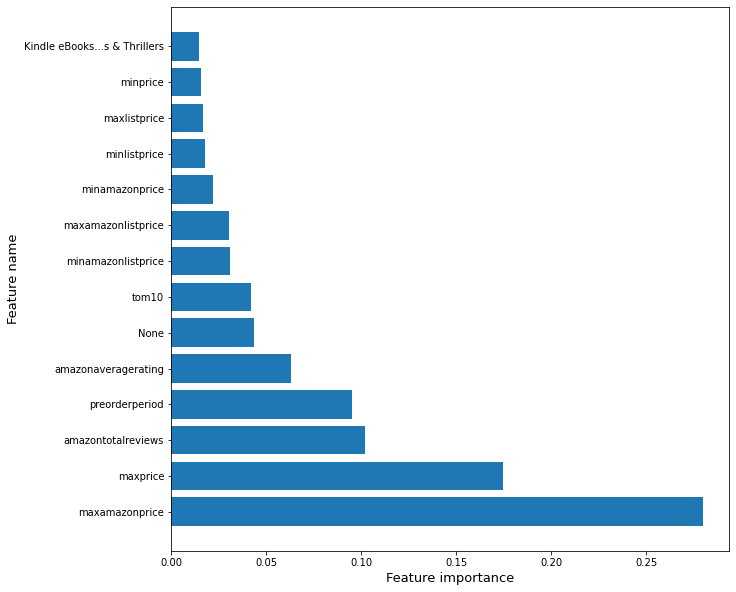

In [56]:
plt.figure(figsize=(10,10))
feature_importance = pd.DataFrame(features_short, columns=['features_short'])
feature_importance['features'] = pd.DataFrame(features)
feature_importance['importance'] = pd.DataFrame(gb.feature_importances_)
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
feature_importance.reset_index(drop=True, inplace=True)
feature_importance = feature_importance[np.abs(feature_importance['importance']) != 0]
plt.barh(feature_importance['features_short'][:14], feature_importance['importance'][:14])
plt.xlabel('Feature importance', fontsize=13)
plt.ylabel('Feature name', fontsize=13)
plt.show()

Here we can see that our scatter plot strongly clustered along the 45-degree line, except a few outliers, which is a good thing. The outliers are there because there are data points that have completely different behaviors that are not observed by the training set at all, and does not belong to the distribution of our model.

The same thing happens for **ebooks** and **audios** as well, most of our predictions clustered along the 45-degree line, with some outliers in the extreme case that our model fails to predict. I believe that we need more additional information to help our model to learn those data points.

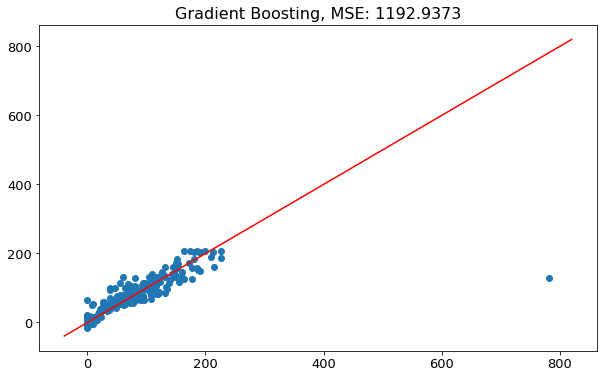

In [68]:
y_pred = gb.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
x = np.linspace(*plt.xlim())
plt.plot(x, x, c='r')
plt.title('Gradient Boosting, MSE: {:.4f}'.format(mean_squared_error(y_pred, y_test)), fontsize=16)
plt.show()

In [92]:
X_train, X_test, y_train, y_test = train_test_split(TWD_2[features].fillna(0), TWD_2['totalunits'])
gb = GradientBoostingRegressor(max_depth=8, min_samples_leaf=64, min_samples_split=100).fit(X_train, y_train)

print('MSE loss (training): {:.4f}'.format(mean_squared_error(gb.predict(X_train), y_train)))
print('MSE loss (test): {:.4f}'.format(mean_squared_error(gb.predict(X_test), y_test)))

MSE loss (training): 546.9054
MSE loss (test): 237.1022


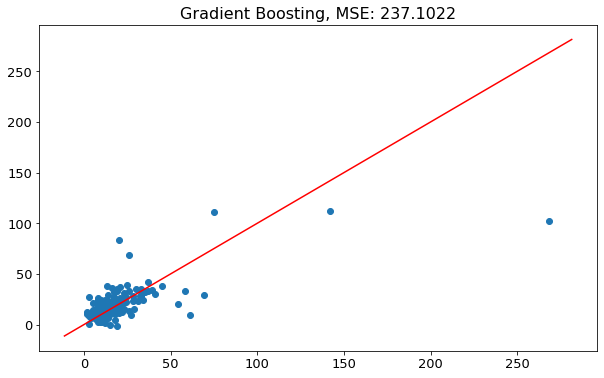

In [93]:
y_pred = gb.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
x = np.linspace(*plt.xlim())
plt.plot(x, x, c='r')
plt.title('Gradient Boosting, MSE: {:.4f}'.format(mean_squared_error(y_pred, y_test)), fontsize=16)
plt.show()

In [88]:
X_train, X_test, y_train, y_test = train_test_split(TWD_3[features].fillna(0), TWD_3['totalunits'])
gb = GradientBoostingRegressor(max_depth=8, min_samples_leaf=64, min_samples_split=100).fit(X_train, y_train)

print('MSE loss (training): {:.4f}'.format(mean_squared_error(gb.predict(X_train), y_train)))
print('MSE loss (test): {:.4f}'.format(mean_squared_error(gb.predict(X_test), y_test)))

MSE loss (training): 254.1469
MSE loss (test): 78.6974


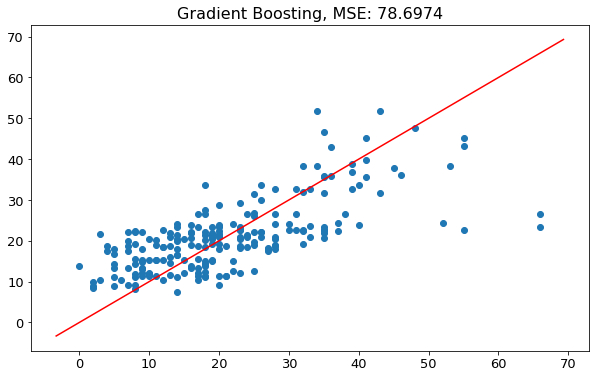

In [89]:
y_pred = gb.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
x = np.linspace(*plt.xlim())
plt.plot(x, x, c='r')
plt.title('Gradient Boosting, MSE: {:.4f}'.format(mean_squared_error(y_pred, y_test)), fontsize=16)
plt.show()

---

## Time Series Analysis

Here since we see a strong pattern and correlation between the data features and the revenue, I want to build a time series model to fit the data, and make predictions about the future tendencies of the revenue.

Remember that we might have all negative data to be zeros for the revenue, represented as the straight line near zero, our model need to take these values as potentially negative in the prediction. Following are visualizations of the revenue when `formattype` is **print**.

In [94]:
AITD = data[data['entity'] == 'Alone in the dark']
TWD = data[data['entity'] == 'The Walking Dead']
AITD_1 = AITD[AITD.formattype == 'print']
TWD_1 = TWD[TWD.formattype == 'print']

AITD_time = [datetime.datetime.strptime(str(i), '%Y%m%d') for i in AITD_1.fromdate.unique()]
TWD_time = [datetime.datetime.strptime(str(i), '%Y%m%d') for i in TWD_1.fromdate.unique()]

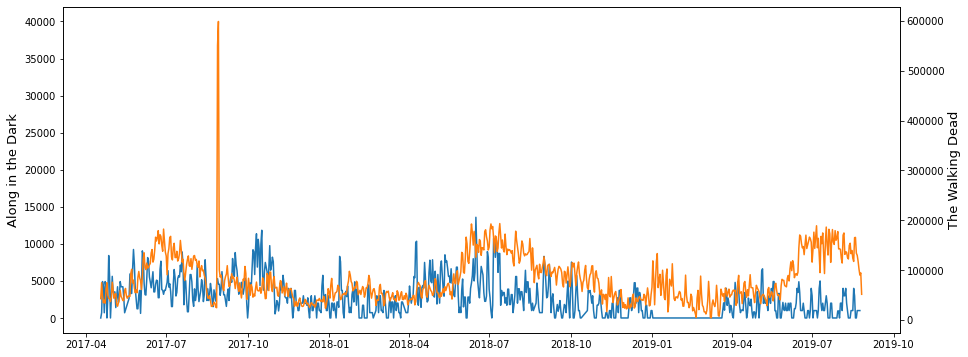

In [95]:
fig, ax1 = plt.subplots(figsize=(15, 6))
ax2 = ax1.twinx()
ax1.plot(AITD_time, AITD_1.groupby('fromdate').sum().totalrevenue.values, c='C0')
ax2.plot(TWD_time, TWD_1.groupby('fromdate').sum().totalrevenue.values, c='C1')
ax1.set_ylim(-2000, 42000)
ax1.set_ylabel('Along in the Dark', fontsize=13)
ax2.set_ylabel('The Walking Dead', fontsize=13)

plt.show()

In [96]:
AITD_revenue = pd.DataFrame(AITD_time, columns=['ds'])
AITD_revenue['y'] = pd.DataFrame(AITD_1.groupby('fromdate').sum().totalrevenue.values)

TWD_revenue = pd.DataFrame(TWD_time, columns=['ds'])
TWD_revenue['y'] = pd.DataFrame(TWD_1.groupby('fromdate').sum().totalrevenue.values)

And here are the result for the training data, as well as a prediction for the future 200 days. It turns out that the result for **Alone in the Dark** is not so good with a wider confidence interval. Whereas the prediction on **The Walking Dead** yields a much stronger result. It shows that there is a high peak of revenue in the July for every year, and a reletively small peak in the January.

I also include the result for **ebook** and **audio**, however, the model does not perform well compared with **print**. However, we can still see a decreasing trend for **Alone in the Dark** in both format types. And the revenue has a similar peak in Jupy every year for **The Walking Dead**.

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


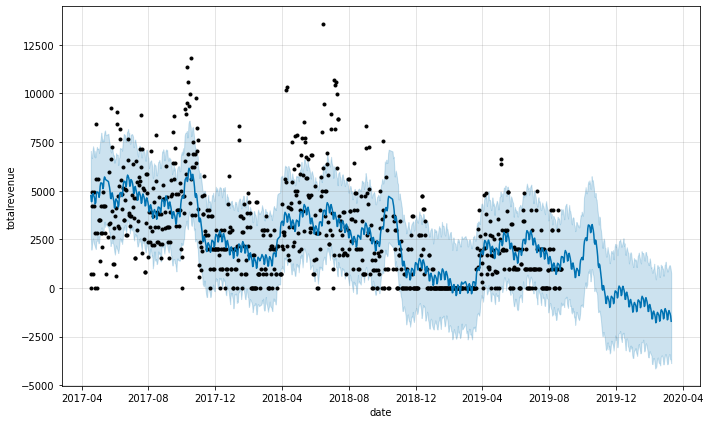

In [97]:
AITD_prophet = fbprophet.Prophet(changepoint_prior_scale=0.005, daily_seasonality=True)
AITD_prophet.fit(AITD_revenue)
AITD_forecast = AITD_prophet.make_future_dataframe(periods=200, freq='D')
AITD_forecast = AITD_prophet.predict(AITD_forecast)
AITD_prophet.plot(AITD_forecast, xlabel = 'date', ylabel = 'totalrevenue');

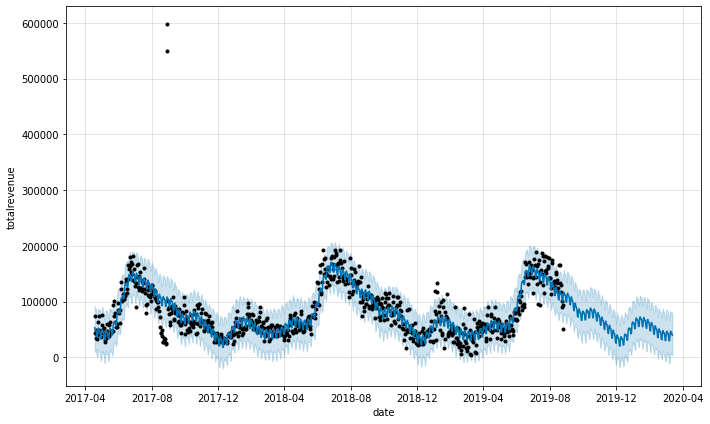

In [98]:
TWD_prophet = fbprophet.Prophet(changepoint_prior_scale=0.05, daily_seasonality=True)
TWD_prophet.fit(TWD_revenue)
TWD_forecast = TWD_prophet.make_future_dataframe(periods=200, freq='D')
TWD_forecast = TWD_prophet.predict(TWD_forecast)
TWD_prophet.plot(TWD_forecast, xlabel = 'date', ylabel = 'totalrevenue');

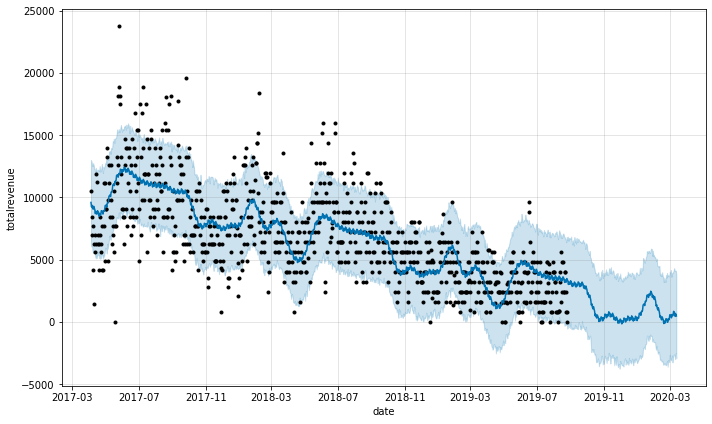

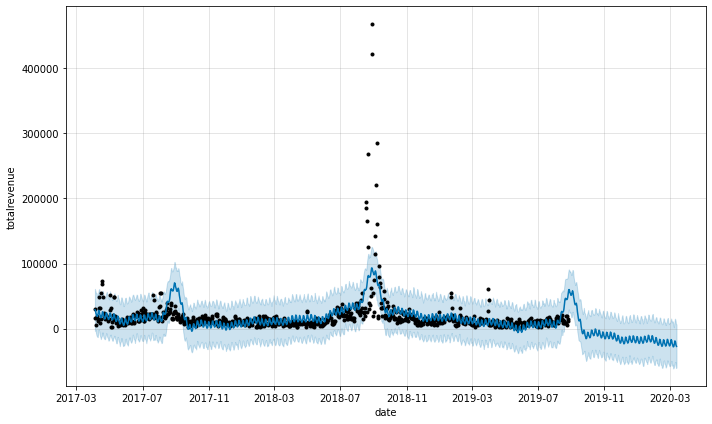

In [99]:
AITD_2 = AITD[AITD.formattype == 'ebook']
TWD_2 = TWD[TWD.formattype == 'ebook']

AITD_time = [datetime.datetime.strptime(str(i), '%Y%m%d') for i in AITD_2.fromdate.unique()]
TWD_time = [datetime.datetime.strptime(str(i), '%Y%m%d') for i in TWD_2.fromdate.unique()]

AITD_revenue = pd.DataFrame(AITD_time, columns=['ds'])
AITD_revenue['y'] = pd.DataFrame(AITD_2.groupby('fromdate').sum().totalrevenue.values)

TWD_revenue = pd.DataFrame(TWD_time, columns=['ds'])
TWD_revenue['y'] = pd.DataFrame(TWD_2.groupby('fromdate').sum().totalrevenue.values)

AITD_prophet = fbprophet.Prophet(changepoint_prior_scale=0.005, daily_seasonality=True)
AITD_prophet.fit(AITD_revenue)
AITD_forecast = AITD_prophet.make_future_dataframe(periods=200, freq='D')
AITD_forecast = AITD_prophet.predict(AITD_forecast)
AITD_prophet.plot(AITD_forecast, xlabel = 'date', ylabel = 'totalrevenue');

TWD_prophet = fbprophet.Prophet(changepoint_prior_scale=0.05, daily_seasonality=True)
TWD_prophet.fit(TWD_revenue)
TWD_forecast = TWD_prophet.make_future_dataframe(periods=200, freq='D')
TWD_forecast = TWD_prophet.predict(TWD_forecast)
TWD_prophet.plot(TWD_forecast, xlabel = 'date', ylabel = 'totalrevenue');

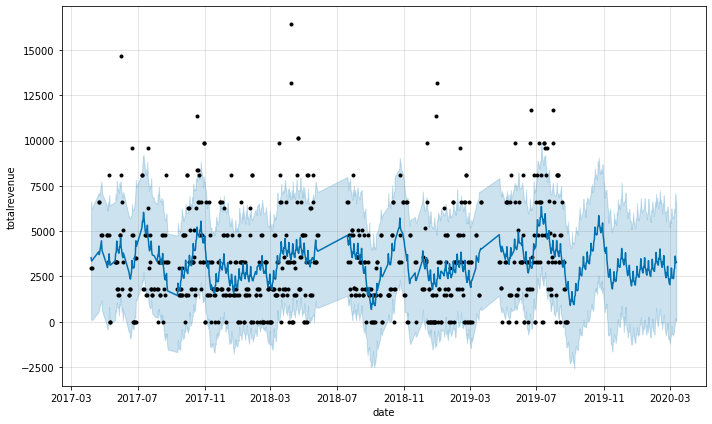

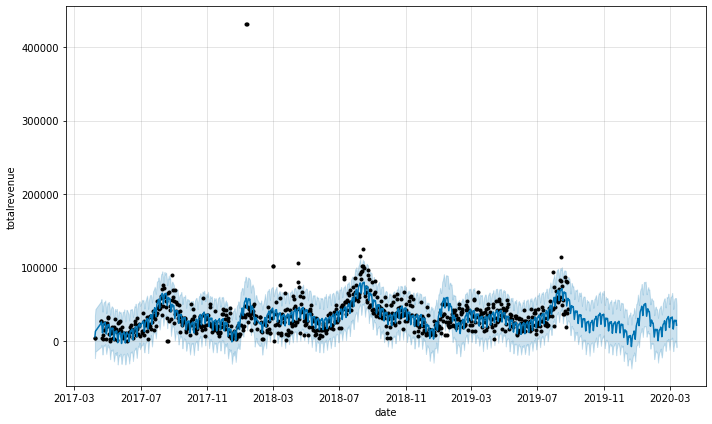

In [100]:
AITD_3 = AITD[AITD.formattype == 'audio']
TWD_3 = TWD[TWD.formattype == 'audio']

AITD_time = [datetime.datetime.strptime(str(i), '%Y%m%d') for i in AITD_3.fromdate.unique()]
TWD_time = [datetime.datetime.strptime(str(i), '%Y%m%d') for i in TWD_3.fromdate.unique()]

AITD_revenue = pd.DataFrame(AITD_time, columns=['ds'])
AITD_revenue['y'] = pd.DataFrame(AITD_3.groupby('fromdate').sum().totalrevenue.values)

TWD_revenue = pd.DataFrame(TWD_time, columns=['ds'])
TWD_revenue['y'] = pd.DataFrame(TWD_3.groupby('fromdate').sum().totalrevenue.values)

AITD_prophet = fbprophet.Prophet(changepoint_prior_scale=0.005, daily_seasonality=True)
AITD_prophet.fit(AITD_revenue)
AITD_forecast = AITD_prophet.make_future_dataframe(periods=200, freq='D')
AITD_forecast = AITD_prophet.predict(AITD_forecast)
AITD_prophet.plot(AITD_forecast, xlabel = 'date', ylabel = 'totalrevenue');

TWD_prophet = fbprophet.Prophet(changepoint_prior_scale=0.05, daily_seasonality=True)
TWD_prophet.fit(TWD_revenue)
TWD_forecast = TWD_prophet.make_future_dataframe(periods=200, freq='D')
TWD_forecast = TWD_prophet.predict(TWD_forecast)
TWD_prophet.plot(TWD_forecast, xlabel = 'date', ylabel = 'totalrevenue');